## Output Probabilities for all subjects and ROC curve inputs for some kind of statistical anlysis of ROC curves

From request [ROC Output and Probabilities](https://trello.com/c/JcZRCXte)

## Imports and Function Definitions

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    print("TRAINNG PROBABILITIES")
    for a,b in zip(y, clf.predict_proba(X)[:,1]):
        print(a,b)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    print("TESTING PROBABILITIES")
    for a,b in zip(Y_test,y_pred_prob):
        print(a,b)
    
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [15]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('Data_no_UM.xlsx')
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.3s finished


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.77      1.00      0.87        36
          1       1.00      0.91      0.95       124

avg / total       0.95      0.93      0.93       160


Confusion matrix, without normalization
[[ 36   0]
 [ 11 113]]

recall	0.911290322581
precision	1.0
auc	0.95564516129
specificity	1.0
npv	0.765957446809
accuracy	0.93125
weighted_sensitivity	0.911290322581
weighted_ppv	1.0
weighted_specificity	1.0
weighted_npv	0.918518518519
weighted_accuracy	0.95564516129
TRAINNG PROBABILITIES
1 0.999999720716
1 0.999999994335
0 0.086549890113
1 0.99999891187
0 0.15293583919
1 0.996254742394
1 0.965179998321
1 0.999988679828
1 0.975075819236
0 0.0610379727714
1 0.994282660049
1 0.999999999989
1 0.900490113692


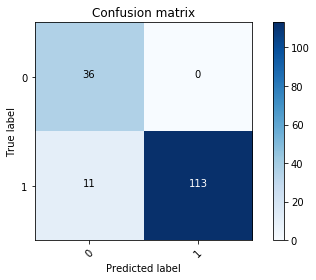

In [16]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [17]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.150100326538	0.0141898341698
score_time	0.0582023143768	0.00613875510458
test_recall	0.931914893617	0.02388291949
train_recall	0.957978723404	0.00701643933951
test_precision	0.988629962215	0.00735903646125
train_precision	0.993380450518	0.0013540944649
test_auc	0.950984184776	0.0195834350562
train_auc	0.969949717136	0.00429535807389
test_specificity	0.970053475936	0.0186067570063
train_specificity	0.981920710868	0.00372569243333
test_npv	0.836815913658	0.0478838498415
train_npv	0.892226238167	0.0159628482059
test_accuracy	0.94187992126	0.0212290623638
train_accuracy	0.964231239268	0.00546311771441
test_weighted_sensitivity	0.931914893617	0.02388291949
train_weighted_sensitivity	0.957978723404	0.00701643933951
test_weighted_ppv	0.9688974827	0.0195366514528
train_weighted_ppv	0.981485043698	0.00377321088083
test_weighted_specificity	0.970053475936	0.0186067570063
train_weighted_specificity	0.981920710868	0.00372569243333
test_weighted_npv	0.93464354193	0.0223061403758
train_we

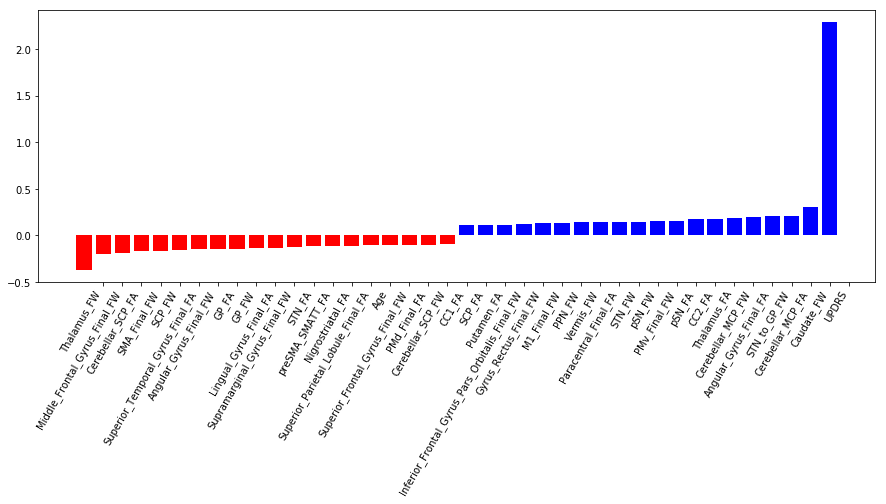

Age	-0.103837418017
Sex	0.023030514197
UPDRS	2.28905391441
aSN_FA	-0.0190462598327
Caudate_FA	-0.0443202106969
CC2_FA	0.172746969097
GP_FA	-0.141874659356
LobuleVI_FA	0.0629819068019
LobuleV_FA	-0.0414340710095
MCP_FA	-0.016744163219
pSN_FA	0.160718382871
Putamen_FA	0.116312731255
SCP_FA	0.115947886921
STN_FA	-0.124735017013
Thalamus_FA	0.17463318472
Vermis_FA	0.0523961752357
RN_FA	0.0181987438097
PPN_FA	0.00102835812657
Dentate_FA	0.00109939344364
CC1_FA	-0.0870398274152
aSN_FW	-0.00507212485617
Caudate_FW	0.311151898339
CC2_FW	3.58830798647e-05
GP_FW	-0.140860940353
LobuleVI_FW	-0.0278790182943
LobuleV_FW	-0.0560738830591
MCP_FW	0.0338019692649
pSN_FW	0.148823966826
Putamen_FW	-0.0824747107209
SCP_FW	-0.163061664668
STN_FW	0.146613049283
Thalamus_FW	-0.366491721429
Vermis_FW	0.14318797042
RN_FW	0.0588710474705
PPN_FW	0.137990660021
Dentate_FW	0.00792226021113
CC1_FW	-0.0542273567513
Angular_Gyrus_Final_FA	0.200688065992
Anterior_Orbital_Gyrus_Final_FA	0.105024203521
Calcarine_Sulcus_

In [18]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.77      1.00      0.87        36
          1       1.00      0.91      0.95       124

avg / total       0.95      0.93      0.93       160

TESTING PROBABILITIES
0 0.14210399909
1 0.999999999894
1 0.99999999786
1 0.999999984964
1 1.0
1 0.999999909509
1 0.999999450166
1 0.380817735889
0 0.161932068835
0 0.228912658505
1 0.878918383053
1 1.0
1 0.9999999912
1 0.962910630453
1 0.995426376616
1 0.999999999984
1 0.99999989441
0 0.0370183661063
1 0.960639788138
1 0.999999431556
0 0.0783158231061
1 0.983034760945
0 0.0602464788013
1 0.951296513527
1 0.908906208525
1 0.999999798607
0 0.0532239340847
0 0.214328226912
1 0.969537408234
0 0.0208303477822
1 0.980390828342
1 0.999996610928
1 0.567483933393
1 0.999999998469
1 0.664737527472
0 0.166091232763
1 0.999999999997
1 0.97642498229
1 0.995177149429
1 0.303314148377
1 0.999996507189
0 0.0517576176066
0 0.115897439782
1 0.996971254186
0 0.431843676716
1 0.999999998496
1 0

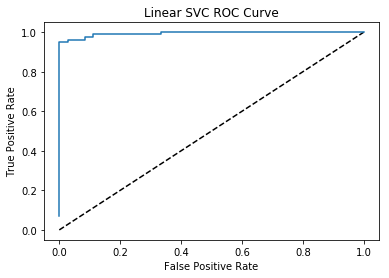

0.0 0.0725806451613
0.0 0.951612903226
0.0277777777778 0.951612903226
0.0277777777778 0.959677419355
0.0833333333333 0.959677419355
0.0833333333333 0.975806451613
0.111111111111 0.975806451613
0.111111111111 0.991935483871
0.333333333333 0.991935483871
0.333333333333 1.0
1.0 1.0


In [19]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.1s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.94      0.99      0.96        82
          1       0.97      0.86      0.91        37

avg / total       0.95      0.95      0.95       119


Confusion matrix, without normalization
[[81  1]
 [ 5 32]]

recall	0.864864864865
precision	0.969696969697
auc	0.926334871457
specificity	0.987804878049
npv	0.941860465116
accuracy	0.949579831933
weighted_sensitivity	0.864864864865
weighted_ppv	0.986095452837
weighted_specificity	0.987804878049
weighted_npv	0.879659524508
weighted_accuracy	0.926334871457
TRAINNG PROBABILITIES
0 0.0332678739422
0 0.163808604481
0 0.2691751376
0 0.108672077274
0 0.274487455902
0 0.0348435006468
1 0.992288268905
0 0.0260965733891
0 0.164920835283
0 0.0784211232278


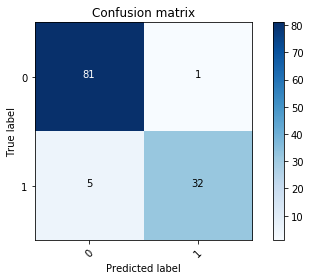

In [20]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [21]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0626509189606	0.00273587089525
score_time	0.0347091197968	0.00270524656047
test_recall	0.778253968254	0.022646738828
train_recall	0.836666666667	0.020412229711
test_precision	0.876794629944	0.0883812998491
train_precision	0.918930202016	0.00700201543368
test_auc	0.854098735539	0.0313402705843
train_auc	0.896593444909	0.00970848315929
test_specificity	0.929943502825	0.059015890159
train_specificity	0.956520223152	0.0042811842338
test_npv	0.876688084544	0.0126852293852
train_npv	0.908796166142	0.0102146792364
test_accuracy	0.873657614782	0.0377062689241
train_accuracy	0.912109166815	0.00712526452264
test_weighted_sensitivity	0.778253968254	0.022646738828
train_weighted_sensitivity	0.836666666667	0.020412229711
test_weighted_ppv	0.921629021272	0.0597668182638
train_weighted_ppv	0.950628423002	0.00431182152932
test_weighted_specificity	0.929943502825	0.059015890159
train_weighted_specificity	0.956520223152	0.0042811842338
test_weighted_npv	0.807221241007	0.0189261886419
train_we

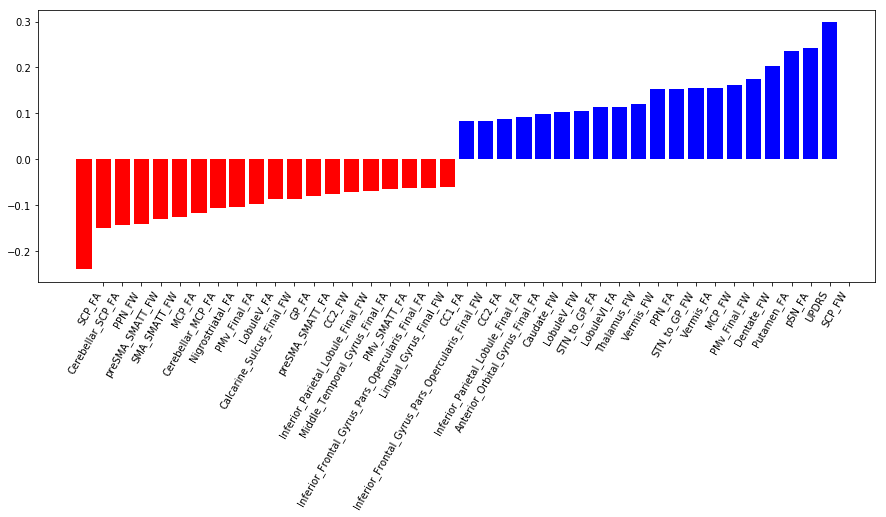

Age	0.0464435402652
Sex	0.0
UPDRS	0.242157690445
aSN_FA	0.0514614104887
Caudate_FA	-0.00458769911515
CC2_FA	0.0833301192507
GP_FA	-0.0870440916489
LobuleVI_FA	0.113708911533
LobuleV_FA	-0.0986670561786
MCP_FA	-0.12545182245
pSN_FA	0.235857304764
Putamen_FA	0.203770120295
SCP_FA	-0.240309978704
STN_FA	0.0622586204428
Thalamus_FA	0.0300147957895
Vermis_FA	0.155086020999
RN_FA	-0.025344955884
PPN_FA	0.15255159316
Dentate_FA	0.0147775670029
CC1_FA	-0.0613416773379
aSN_FW	-0.0138329164496
Caudate_FW	0.0985259949361
CC2_FW	-0.0760814084926
GP_FW	0.0566673946784
LobuleVI_FW	0.0486187887013
LobuleV_FW	0.103251550765
MCP_FW	0.155672058861
pSN_FW	-0.0163520091876
Putamen_FW	0.00429783194829
SCP_FW	0.298784323624
STN_FW	0.060890078391
Thalamus_FW	0.114026478636
Vermis_FW	0.119874124723
RN_FW	-0.00767294418354
PPN_FW	-0.144373786992
Dentate_FW	0.1749856468
CC1_FW	0.0242181782768
Angular_Gyrus_Final_FA	-0.000692031748589
Anterior_Orbital_Gyrus_Final_FA	0.0918055530974
Calcarine_Sulcus_Final_FA	-0.0

In [22]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.94      0.99      0.96        82
          1       0.97      0.86      0.91        37

avg / total       0.95      0.95      0.95       119

TESTING PROBABILITIES
0 0.0612048863563
0 0.0284898729523
1 0.899090211783
0 0.124284440929
1 0.681429464349
0 0.0766182309411
0 0.102266503665
1 0.849844366634
0 0.0639752803346
1 0.852990435643
0 0.0235856452474
0 0.216319408871
1 0.938580331481
0 0.0285604373997
0 0.264794158405
1 0.0971487208397
1 0.773701001064
0 0.196906619104
1 0.835753545069
1 0.816823819188
1 0.969498019251
1 0.85050186402
0 0.0199703523496
0 0.151840985714
0 0.107327289844
0 0.110747493246
1 0.993723862999
0 0.036560562062
1 0.991850222993
0 0.029547456757
0 0.0618178278015
0 0.0519281436467
0 0.13967863451
0 0.080372680886
1 0.552344695233
0 0.060306339774
0 0.0340207184097
1 0.971444499323
0 0.0720181210444
0 0.142960106739
1 0.541176897589
0 0.0351416163109
1 0.219632294295
1 0.975890692278
1 0.

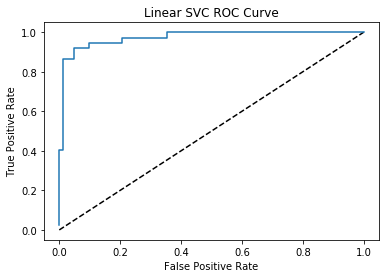

0.0 0.027027027027
0.0 0.405405405405
0.0121951219512 0.405405405405
0.0121951219512 0.864864864865
0.0487804878049 0.864864864865
0.0487804878049 0.918918918919
0.0975609756098 0.918918918919
0.0975609756098 0.945945945946
0.207317073171 0.945945945946
0.207317073171 0.972972972973
0.353658536585 0.972972972973
0.353658536585 1.0
1.0 1.0


In [23]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished


Best parameters set found on development set:

{'classifier__C': 0.0023357214690901212}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       107
          1       0.67      0.67      0.67        12

avg / total       0.93      0.93      0.93       119


Confusion matrix, without normalization
[[103   4]
 [  4   8]]

recall	0.666666666667
precision	0.666666666667
auc	0.814641744548
specificity	0.96261682243
npv	0.96261682243
accuracy	0.932773109244
weighted_sensitivity	0.666666666667
weighted_ppv	0.946902654867
weighted_specificity	0.96261682243
weighted_npv	0.742788461538
weighted_accuracy	0.814641744548
TRAINNG PROBABILITIES
0 0.0666644952693
0 0.224933962739
0 0.0846871158136
0 0.0387420676009
0 0.048502247349
0 0.0215908210263
0 0.0982183569801
0 0.114338649442
0 0.0520751694481
0 0.038778

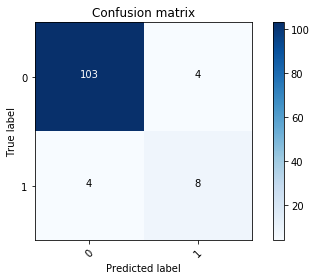

In [24]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [25]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0913566589355	0.00403401114573
score_time	0.0495987415314	0.00164849534826
test_recall	0.584761904762	0.0977478824634
train_recall	0.753478523896	0.0277570831953
test_precision	0.633452380952	0.138615808635
train_precision	0.676166116304	0.0335112240134
test_auc	0.757612433862	0.0434009659066
train_auc	0.844169987098	0.0108579780683
test_specificity	0.930462962963	0.041870966901
train_specificity	0.934861450301	0.0117933896796
test_npv	0.926486846487	0.0152345601561
train_npv	0.955066081112	0.00446473903977
test_accuracy	0.877751959686	0.0306034267013
train_accuracy	0.907363737393	0.00776382613487
test_weighted_sensitivity	0.584761904762	0.0977478824634
train_weighted_sensitivity	0.753478523896	0.0277570831953
test_weighted_ppv	0.899182848593	0.0491257647188
train_weighted_ppv	0.920789729348	0.0111486419372
test_weighted_specificity	0.930462962963	0.041870966901
train_weighted_specificity	0.934861450301	0.0117933896796
test_weighted_npv	0.694813971977	0.0427574362398
train_w

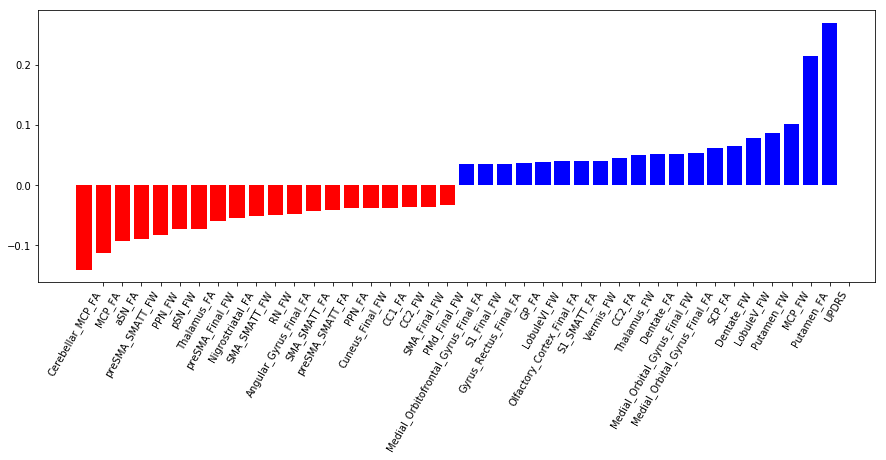

Age	-0.00508100034189
Sex	0.0
UPDRS	0.270140631243
aSN_FA	-0.0928216424261
Caudate_FA	-0.0207427498642
CC2_FA	0.0453486595951
GP_FA	0.0370823662828
LobuleVI_FA	-0.0264144247703
LobuleV_FA	-0.0293308032885
MCP_FA	-0.113014062811
pSN_FA	0.0229285237636
Putamen_FA	0.214894400667
SCP_FA	0.0616471096051
STN_FA	-0.0224753079409
Thalamus_FA	-0.0725318025868
Vermis_FA	0.00459801997685
RN_FA	-0.0155122031482
PPN_FA	-0.0384434813006
Dentate_FA	0.0513783571989
CC1_FA	-0.0377344802083
aSN_FW	-0.0151491864959
Caudate_FW	0.0312619796107
CC2_FW	-0.0367535552366
GP_FW	-0.00399028220122
LobuleVI_FW	0.0390535726677
LobuleV_FW	0.0777290932751
MCP_FW	0.101527387206
pSN_FW	-0.0728605388662
Putamen_FW	0.0872071062524
SCP_FW	0.0237601128586
STN_FW	-0.0107145111352
Thalamus_FW	0.0505402767959
Vermis_FW	0.0407653955826
RN_FW	-0.0496933744363
PPN_FW	-0.082944363399
Dentate_FW	0.0648676714551
CC1_FW	-0.0137170312728
Angular_Gyrus_Final_FA	-0.0474626746047
Anterior_Orbital_Gyrus_Final_FA	0.023601098722
Calcarine_

In [26]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       107
          1       0.67      0.67      0.67        12

avg / total       0.93      0.93      0.93       119

TESTING PROBABILITIES
0 0.0839237564461
0 0.0219206194911
0 0.106163946588
0 0.0537138994013
0 0.358595141146
0 0.18131061211
0 0.101950708337
1 0.672572597448
0 0.0231076544972
0 0.00278824749439
0 0.0311875319943
0 0.0474122269883
0 0.056362611136
0 0.00555574142859
0 0.0525693360541
1 0.177379473168
0 0.0443724803682
0 0.0334683706831
1 0.612077271292
0 0.112917361777
0 0.0556761869812
1 0.885038006937
0 0.0150728470881
0 0.0777658212015
0 0.0476435662554
0 0.0324088080977
0 0.0218117076848
0 0.0715265938018
0 0.0560547723898
0 0.0408685069197
0 0.0213456038937
0 0.0840875109173
0 0.081174536091
0 0.0698321776098
0 0.0300069854245
0 0.0549540280962
0 0.0684714633452
1 0.836888276598
0 0.0901418934397
0 0.0265600316123
0 0.0667505529123
0 0.0603197346101
1 0.197233392998
0

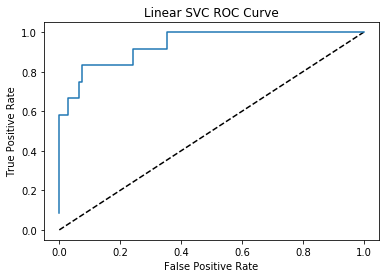

0.0 0.0833333333333
0.0 0.583333333333
0.0280373831776 0.583333333333
0.0280373831776 0.666666666667
0.0654205607477 0.666666666667
0.0654205607477 0.75
0.0747663551402 0.75
0.0747663551402 0.833333333333
0.242990654206 0.833333333333
0.242990654206 0.916666666667
0.355140186916 0.916666666667
0.355140186916 1.0
1.0 1.0


In [27]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.97      1.00      0.98        94
          1       1.00      0.88      0.94        25

avg / total       0.98      0.97      0.97       119


Confusion matrix, without normalization
[[94  0]
 [ 3 22]]

recall	0.88
precision	1.0
auc	0.94
specificity	1.0
npv	0.969072164948
accuracy	0.974789915966
weighted_sensitivity	0.88
weighted_ppv	1.0
weighted_specificity	1.0
weighted_npv	0.892857142857
weighted_accuracy	0.94
TRAINNG PROBABILITIES
0 0.00711570819314
0 0.0369861815599
0 0.226907027696
0 0.0540899645321
0 0.125934545794
0 0.0703297340813
1 0.989829191633
0 0.00445615182242
0 0.18865778927
0 0.0525905232658
0 0.0702802611684
0 0.0168517571609
1 0.380146618772
0 0.0295513616634
1 0.0613

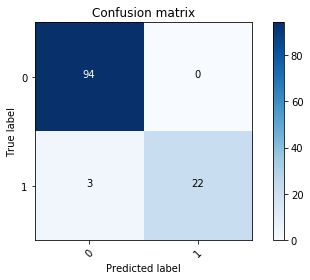

In [28]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [29]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0585123538971	0.00402436674984
score_time	0.0324259281158	0.00188175889532
test_recall	0.808571428571	0.078558440485
train_recall	0.86546184739	0.0227891742315
test_precision	0.847455659609	0.102057803498
train_precision	0.928277261611	0.0236792708783
test_auc	0.8827001287	0.0506069011935
train_auc	0.923298764263	0.0128419795165
test_specificity	0.956828828829	0.0324687684341
train_specificity	0.981135681136	0.00659054298449
test_npv	0.946741057513	0.021890001647
train_npv	0.96299265416	0.00622597012714
test_accuracy	0.924318775663	0.0383614579759
train_accuracy	0.955801811574	0.00831705436063
test_weighted_sensitivity	0.808571428571	0.078558440485
train_weighted_sensitivity	0.86546184739	0.0227891742315
test_weighted_ppv	0.948519884974	0.038243556692
train_weighted_ppv	0.978648415373	0.00750231074394
test_weighted_specificity	0.956828828829	0.0324687684341
train_weighted_specificity	0.981135681136	0.00659054298449
test_weighted_npv	0.836272782203	0.0606885915824
train_weigh

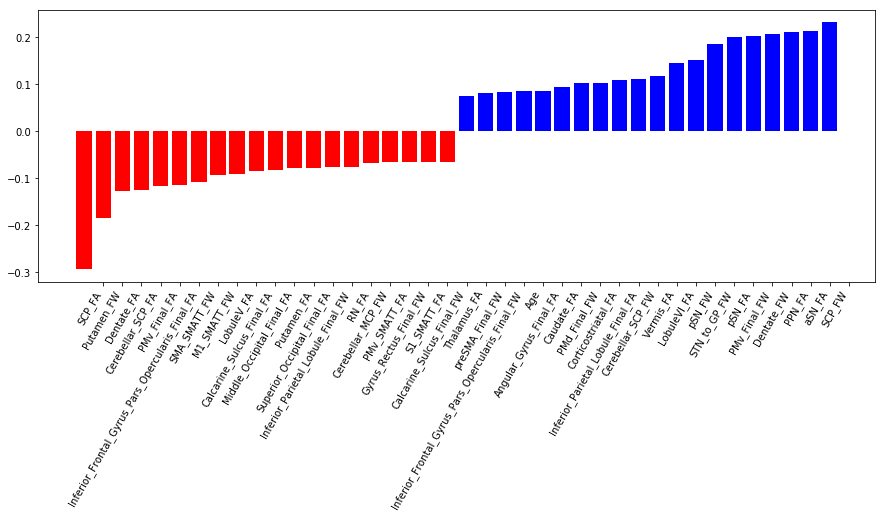

Age	0.0848403976358
Sex	0.0
UPDRS	-0.0615531651754
aSN_FA	0.213158911673
Caudate_FA	0.0948257005697
CC2_FA	0.0491290763417
GP_FA	-0.0534231768719
LobuleVI_FA	0.144347372384
LobuleV_FA	-0.0912897381445
MCP_FA	0.0316362499916
pSN_FA	0.199899718544
Putamen_FA	-0.0778954210115
SCP_FA	-0.293893183217
STN_FA	0.0200630543812
Thalamus_FA	0.0749255181745
Vermis_FA	0.116214234179
RN_FA	-0.0769924962826
PPN_FA	0.211374692456
Dentate_FA	-0.128068279713
CC1_FA	-0.0610362033344
aSN_FW	0.034450485994
Caudate_FW	0.0491909859045
CC2_FW	0.0475088232141
GP_FW	0.030053613839
LobuleVI_FW	-0.00223042489427
LobuleV_FW	-0.0123993257816
MCP_FW	0.022889737223
pSN_FW	0.150486609721
Putamen_FW	-0.184370147611
SCP_FW	0.231707332828
STN_FW	0.0546193179249
Thalamus_FW	0.0214534520624
Vermis_FW	0.00801049635863
RN_FW	0.0127631209447
PPN_FW	-0.000673810586784
Dentate_FW	0.206174097078
CC1_FW	-0.0269792147388
Angular_Gyrus_Final_FA	0.0853771138875
Anterior_Orbital_Gyrus_Final_FA	0.0339168031202
Calcarine_Sulcus_Final_F

In [30]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.97      1.00      0.98        94
          1       1.00      0.88      0.94        25

avg / total       0.98      0.97      0.97       119

TESTING PROBABILITIES
0 0.0209009046706
0 0.015468616513
1 0.725908420046
0 0.0635069289147
1 0.0644013601311
0 0.0120661659209
0 0.0213834802432
0 0.0237286030535
0 0.0306342123167
1 0.96495994819
0 0.00703964386375
0 0.156115805902
1 0.962441499847
0 0.05178153037
0 0.084420541851
0 0.0130850100356
1 0.6809362141
0 0.268424038866
0 0.0587074938674
1 0.966098345613
1 0.869469134786
0 0.0306740228771
0 0.0268129255871
0 0.0616603618097
0 0.0500453821904
0 0.0519412981885
1 0.97756057359
0 0.0136962675109
1 0.979414441554
0 0.0200255220922
0 0.103134734969
0 0.0101558198852
0 0.0419174917629
0 0.116428548235
1 0.715015134084
0 0.0122341136146
0 0.0155192172797
0 0.0716967193357
0 0.0192008199458
0 0.180258491193
1 0.46563128583
0 0.0071723797194
0 0.0333779890691
1 0.99429284

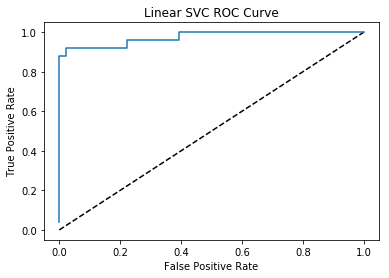

0.0 0.04
0.0 0.88
0.0212765957447 0.88
0.0212765957447 0.92
0.223404255319 0.92
0.223404255319 0.96
0.393617021277 0.96
0.393617021277 1.0
1.0 1.0


In [31]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    9.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.67      0.77      0.71        13
          1       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43


Confusion matrix, without normalization
[[10  3]
 [ 5 25]]

recall	0.833333333333
precision	0.892857142857
auc	0.801282051282
specificity	0.769230769231
npv	0.666666666667
accuracy	0.813953488372
weighted_sensitivity	0.833333333333
weighted_ppv	0.78313253012
weighted_specificity	0.769230769231
weighted_npv	0.821917808219
weighted_accuracy	0.801282051282
TRAINNG PROBABILITIES
1 0.572099127649
0 0.0939253366026
0 0.525250626762
1 0.783652940442
1 0.978921778906
1 0.886606924731
1 0.638988556037
0 0.165660980022
1 0.96601224617
1 0.904760467338
1 0

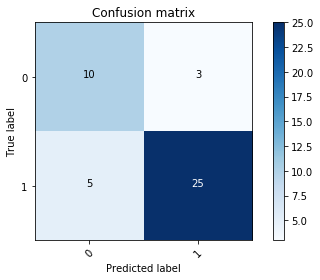

In [32]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [33]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0115067481995	0.00100116271884
score_time	0.0118069171906	0.00147460004552
test_recall	0.858947368421	0.0729398492365
train_recall	0.881234177215	0.0263255383405
test_precision	0.923698830409	0.0264310503776
train_precision	0.986255086072	0.0122710423822
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.900952380952	0.0358125631942
train_specificity	0.982330827068	0.0158331734056
test_npv	0.826587301587	0.078020353825
train_npv	0.856753770423	0.0255876012875
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634
test_weighted_sensitivity	0.858947368421	0.0729398492365
train_weighted_sensitivity	0.881234177215	0.0263255383405
test_weighted_ppv	0.896990316031	0.0348306237744
train_weighted_ppv	0.980908144509	0.0170788940642
test_weighted_specificity	0.900952380952	0.0358125631942
train_weighted_specificity	0.982330827068	0.0158331734056
test_weighted_npv	0.868289102926	0.0599799614805
train_we

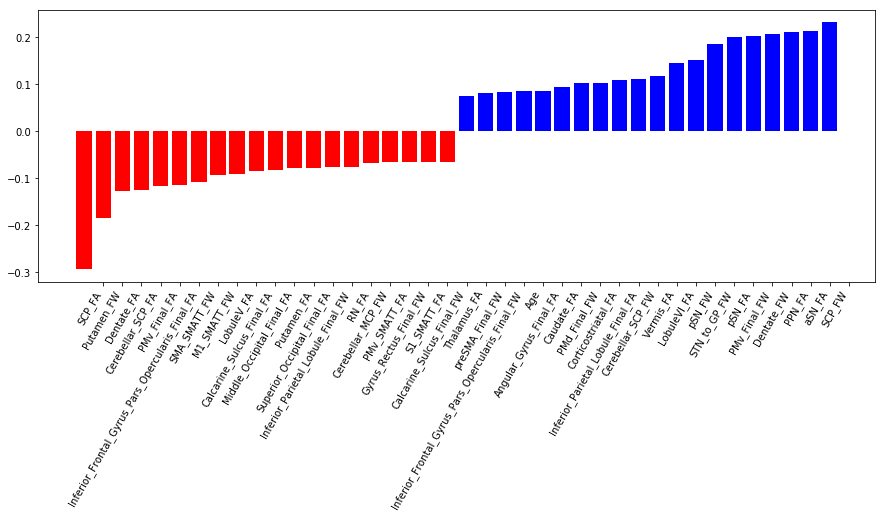

Age	0.0848403976358
Sex	0.0
UPDRS	-0.0615531651754
aSN_FA	0.213158911673
Caudate_FA	0.0948257005697
CC2_FA	0.0491290763417
GP_FA	-0.0534231768719
LobuleVI_FA	0.144347372384
LobuleV_FA	-0.0912897381445
MCP_FA	0.0316362499916
pSN_FA	0.199899718544
Putamen_FA	-0.0778954210115
SCP_FA	-0.293893183217
STN_FA	0.0200630543812
Thalamus_FA	0.0749255181745
Vermis_FA	0.116214234179
RN_FA	-0.0769924962826
PPN_FA	0.211374692456
Dentate_FA	-0.128068279713
CC1_FA	-0.0610362033344
aSN_FW	0.034450485994
Caudate_FW	0.0491909859045
CC2_FW	0.0475088232141
GP_FW	0.030053613839
LobuleVI_FW	-0.00223042489427
LobuleV_FW	-0.0123993257816
MCP_FW	0.022889737223
pSN_FW	0.150486609721
Putamen_FW	-0.184370147611
SCP_FW	0.231707332828
STN_FW	0.0546193179249
Thalamus_FW	0.0214534520624
Vermis_FW	0.00801049635863
RN_FW	0.0127631209447
PPN_FW	-0.000673810586784
Dentate_FW	0.206174097078
CC1_FW	-0.0269792147388
Angular_Gyrus_Final_FA	0.0853771138875
Anterior_Orbital_Gyrus_Final_FA	0.0339168031202
Calcarine_Sulcus_Final_F

In [34]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.67      0.77      0.71        13
          1       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43

TESTING PROBABILITIES
0 0.0296898098363
1 0.993054909309
1 0.13447455911
0 0.73040363666
0 0.235561833929
1 0.993780305239
0 0.935189691822
0 0.302967612301
1 0.897148403177
1 0.788637767479
1 0.340886748965
1 0.955834629721
1 0.404419088118
0 0.870335526205
0 0.0852135648902
1 0.999996517111
1 0.174754483972
1 0.987731088886
1 0.987676871086
1 0.990373384597
0 0.395785737974
1 0.957293451957
1 0.869282933905
0 0.126600908266
1 0.996590864752
1 0.988827550031
1 0.987429443956
1 0.840355525062
1 0.971154556499
1 0.948180995111
1 0.483831919166
0 0.0673038505519
1 0.655407365243
0 0.12035889841
1 0.988825012978
0 0.0353782363896
1 0.988365075356
1 0.969782411729
1 0.779233658018
1 0.914564040928
0 0.33101419243
1 0.969247527566
1 0.726993424522


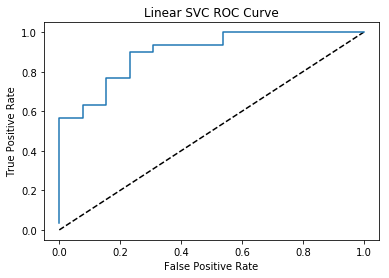

0.0 0.0333333333333
0.0 0.566666666667
0.0769230769231 0.566666666667
0.0769230769231 0.633333333333
0.153846153846 0.633333333333
0.153846153846 0.766666666667
0.230769230769 0.766666666667
0.230769230769 0.9
0.307692307692 0.9
0.307692307692 0.933333333333
0.538461538462 0.933333333333
0.538461538462 1.0
1.0 1.0


In [35]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    9.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.3s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.89      0.83      0.86        30
          1       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43


Confusion matrix, without normalization
[[25  5]
 [ 3 10]]

recall	0.769230769231
precision	0.666666666667
auc	0.801282051282
specificity	0.833333333333
npv	0.892857142857
accuracy	0.813953488372
weighted_sensitivity	0.769230769231
weighted_ppv	0.821917808219
weighted_specificity	0.833333333333
weighted_npv	0.78313253012
weighted_accuracy	0.801282051282
TRAINNG PROBABILITIES
0 0.433696511866
1 0.921229612771
1 0.483161612644
0 0.208931120028
0 0.0173734823549
0 0.104454224697
0 0.366297975499
1 0.853788658261
0 0.0292973446189
0 0.0865782294067


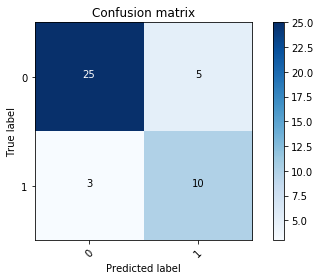

In [36]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [37]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0109188079834	0.00110768885331
score_time	0.011302614212	0.00285630363253
test_recall	0.900952380952	0.0358125631942
train_recall	0.982330827068	0.0158331734056
test_precision	0.826587301587	0.078020353825
train_precision	0.856753770423	0.0255876012875
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.858947368421	0.0729398492365
train_specificity	0.881234177215	0.0263255383405
test_npv	0.923698830409	0.0264310503776
train_npv	0.986255086072	0.0122710423822
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634
test_weighted_sensitivity	0.900952380952	0.0358125631942
train_weighted_sensitivity	0.982330827068	0.0158331734056
test_weighted_ppv	0.868289102926	0.0599799614805
train_weighted_ppv	0.892759970764	0.0201669351064
test_weighted_specificity	0.858947368421	0.0729398492365
train_weighted_specificity	0.881234177215	0.0263255383405
test_weighted_npv	0.896990316031	0.0348306237744
train_wei

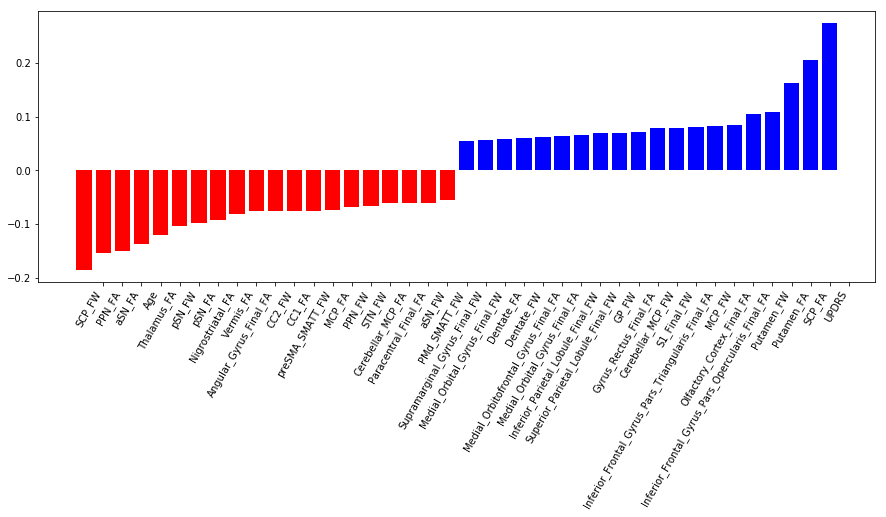

Age	-0.136409040829
Sex	-0.0408684239088
UPDRS	0.275024665333
aSN_FA	-0.149188410171
Caudate_FA	-0.0192993078021
CC2_FA	-0.0246956730561
GP_FA	0.0265136804937
LobuleVI_FA	-0.0381976313152
LobuleV_FA	0.0459978555446
MCP_FA	-0.0742755079312
pSN_FA	-0.0987578471785
Putamen_FA	0.162387844256
SCP_FA	0.205724218313
STN_FA	-0.051307521595
Thalamus_FA	-0.120684730605
Vermis_FA	-0.0809031018927
RN_FA	0.0124111194893
PPN_FA	-0.154205547056
Dentate_FA	0.0591106318817
CC1_FA	-0.0755776173622
aSN_FW	-0.0599536265546
Caudate_FW	-0.0115940011855
CC2_FW	-0.0758295551283
GP_FW	0.0697418831905
LobuleVI_FW	-0.0180495574067
LobuleV_FW	0.0220088302957
MCP_FW	0.0832207237751
pSN_FW	-0.103023628875
Putamen_FW	0.109834222454
SCP_FW	-0.185488485673
STN_FW	-0.0660084277757
Thalamus_FW	-0.0427216064969
Vermis_FW	0.0273440190972
RN_FW	-0.045285295148
PPN_FW	-0.0687590185557
Dentate_FW	0.0601093475301
CC1_FW	-0.0171509994711
Angular_Gyrus_Final_FA	-0.0760822622479
Anterior_Orbital_Gyrus_Final_FA	0.0392220985714
Ca

In [38]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.89      0.83      0.86        30
          1       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43

TESTING PROBABILITIES
1 0.977769850268
0 0.00524816627046
0 0.883539133882
1 0.26448441322
1 0.785154367339
0 0.00468303657268
1 0.0597116117878
1 0.716726930779
0 0.0939165435009
0 0.203821772706
0 0.680840409486
0 0.0390710327057
0 0.613431209221
1 0.120639204451
1 0.929036879831
0 0.000715451715064
0 0.845358381975
0 0.00969985386485
0 0.00973704169166
0 0.00744274064941
1 0.623276289764
0 0.0376559445533
0 0.121621360518
1 0.891046414536
0 0.00245294118148
0 0.00876708943082
0 0.0099379241637
0 0.150805464119
0 0.0244783919149
0 0.0466280743368
0 0.527583252074
1 0.945060494607
0 0.346711186755
1 0.896833033668
0 0.00878801684901
1 0.973327976536
0 0.00913048416099
0 0.0257641623076
0 0.213201396234
0 0.0769356238784
1 0.69160034654
0 0.0262868220746
0 0.268281478039


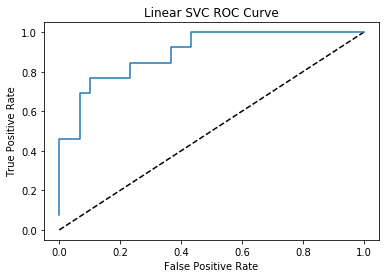

0.0 0.0769230769231
0.0 0.461538461538
0.0666666666667 0.461538461538
0.0666666666667 0.692307692308
0.1 0.692307692308
0.1 0.769230769231
0.233333333333 0.769230769231
0.233333333333 0.846153846154
0.366666666667 0.846153846154
0.366666666667 0.923076923077
0.433333333333 0.923076923077
0.433333333333 1.0
1.0 1.0


In [39]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)

In [40]:
print("Control (0) vs All Parkinsons(1)")
print("TRAIN/VALIDATION")
print(Y_train1.value_counts())
print("TEST")
print(Y_test1.value_counts())
print()
print("=====================================")
print()
print("2. PD(0) vs MSA/PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train2.value_counts())
print("TEST")
print(Y_test2.value_counts())
print()
print("=====================================")
print()
print("MSA (0) vs PD/PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train3.value_counts())
print("TEST")
print(Y_test3.value_counts())
print()
print("=====================================")
print()
print("PSP (0) vs MSA/PD (1)")
print("TRAIN/VALIDATION")
print(Y_train4.value_counts())
print("TEST")
print(Y_test4.value_counts())
print("=====================================")
print()
print("MSA (0) vs PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train5.value_counts())
print("TEST")
print(Y_test5.value_counts())
print()
print("=====================================")
print()
print("PSP (0) vs MSA(1)")
print("TRAIN/VALIDATION")
print(Y_train6.value_counts())
print("TEST")
print(Y_test6.value_counts())
print()


Control (0) vs All Parkinsons(1)
TRAIN/VALIDATION
1    470
0    166
Name: GroupID, dtype: int64
TEST
1    124
0     36
Name: GroupID, dtype: int64


2. PD(0) vs MSA/PSP(1)
TRAIN/VALIDATION
0    299
1    176
Name: GroupID, dtype: int64
TEST
0    82
1    37
Name: GroupID, dtype: int64


MSA (0) vs PD/PSP(1)
TRAIN/VALIDATION
0    403
1     72
Name: GroupID, dtype: int64
TEST
0    107
1     12
Name: GroupID, dtype: int64


PSP (0) vs MSA/PD (1)
TRAIN/VALIDATION
0    371
1    104
Name: GroupID, dtype: int64
TEST
0    94
1    25
Name: GroupID, dtype: int64

MSA (0) vs PSP(1)
TRAIN/VALIDATION
1    99
0    71
Name: GroupID, dtype: int64
TEST
1    30
0    13
Name: GroupID, dtype: int64


PSP (0) vs MSA(1)
TRAIN/VALIDATION
0    99
1    71
Name: GroupID, dtype: int64
TEST
0    30
1    13
Name: GroupID, dtype: int64



In [41]:
import pickle
mod_name = 'both'
pickle.dump(best1, open('./models/%s/park_v_control.pkl' %mod_name, 'wb'))
pickle.dump(best2, open('./models/%s/pd_v_atypical.pkl' %mod_name, 'wb'))
pickle.dump(best3, open('./models/%s/msa_v_pd_psp.pkl' %mod_name, 'wb'))
pickle.dump(best4, open('./models/%s/psp_v_pd_msa.pkl' %mod_name, 'wb'))
pickle.dump(best5, open('./models/%s/psp_v_msa.pkl' %mod_name, 'wb'))